In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from sklearn.tree import (DecisionTreeClassifier as DTC ,
                            DecisionTreeRegressor as DTR ,
                            plot_tree ,
                            export_text)
from sklearn.metrics import (accuracy_score ,
                                log_loss)
from sklearn.ensemble import (RandomForestRegressor as RF,
                                GradientBoostingRegressor as GBR)

from ISLP import load_data

from utils import confusion_table

In [2]:
from ISLP.models import ModelSpec as MS

# Fitting classification trees

In [3]:
carseats = load_data('Carseats')

In [4]:
carseats.shape

(400, 11)

In [5]:
carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [6]:
# Make a categorical variable

high = np.where(carseats.Sales > 8, 'yes', 'no')

In [7]:
# Need to encode quantitative variables ShelveLoc, Urban, US

carseats = pd.get_dummies(carseats, columns=['ShelveLoc', 'Urban', 'US'], drop_first=True)
carseats = carseats.drop(['Sales'], axis = 1)

# reorder columns so the x-array matches what the textbook has. It impacts the log_loss calculation, and I need to determine why

carseats = carseats[['CompPrice','Income','Advertising','Population','Price','ShelveLoc_Good',	'ShelveLoc_Medium',	'Age','Education','Urban_Yes', 'US_Yes']]

In [8]:
feature_names = list(carseats.columns)

In [9]:
x = np.asarray(carseats)

In [10]:
clf = DTC(criterion='entropy',
max_depth=3,
random_state=0)
clf.fit(x, high)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [11]:
accuracy_score(high , clf.predict(x))

0.79

In [12]:
resid_dev = np.sum(log_loss(high , clf.predict_proba(x)))
resid_dev

0.47106470626493574

[Text(0.5, 0.875, 'ShelveLoc_Good <= 0.5\nentropy = 0.977\nsamples = 400\nvalue = [236, 164]'),
 Text(0.25, 0.625, 'Price <= 92.5\nentropy = 0.894\nsamples = 315\nvalue = [217, 98]'),
 Text(0.125, 0.375, 'Income <= 57.0\nentropy = 0.887\nsamples = 46\nvalue = [14, 32]'),
 Text(0.0625, 0.125, 'entropy = 0.881\nsamples = 10\nvalue = [7, 3]'),
 Text(0.1875, 0.125, 'entropy = 0.711\nsamples = 36\nvalue = [7, 29]'),
 Text(0.375, 0.375, 'Advertising <= 13.5\nentropy = 0.804\nsamples = 269\nvalue = [203, 66]'),
 Text(0.3125, 0.125, 'entropy = 0.687\nsamples = 224\nvalue = [183, 41]'),
 Text(0.4375, 0.125, 'entropy = 0.991\nsamples = 45\nvalue = [20, 25]'),
 Text(0.75, 0.625, 'Price <= 135.0\nentropy = 0.767\nsamples = 85\nvalue = [19, 66]'),
 Text(0.625, 0.375, 'US_Yes <= 0.5\nentropy = 0.523\nsamples = 68\nvalue = [8, 60]'),
 Text(0.5625, 0.125, 'entropy = 0.937\nsamples = 17\nvalue = [6, 11]'),
 Text(0.6875, 0.125, 'entropy = 0.239\nsamples = 51\nvalue = [2, 49]'),
 Text(0.875, 0.375, 'Inco

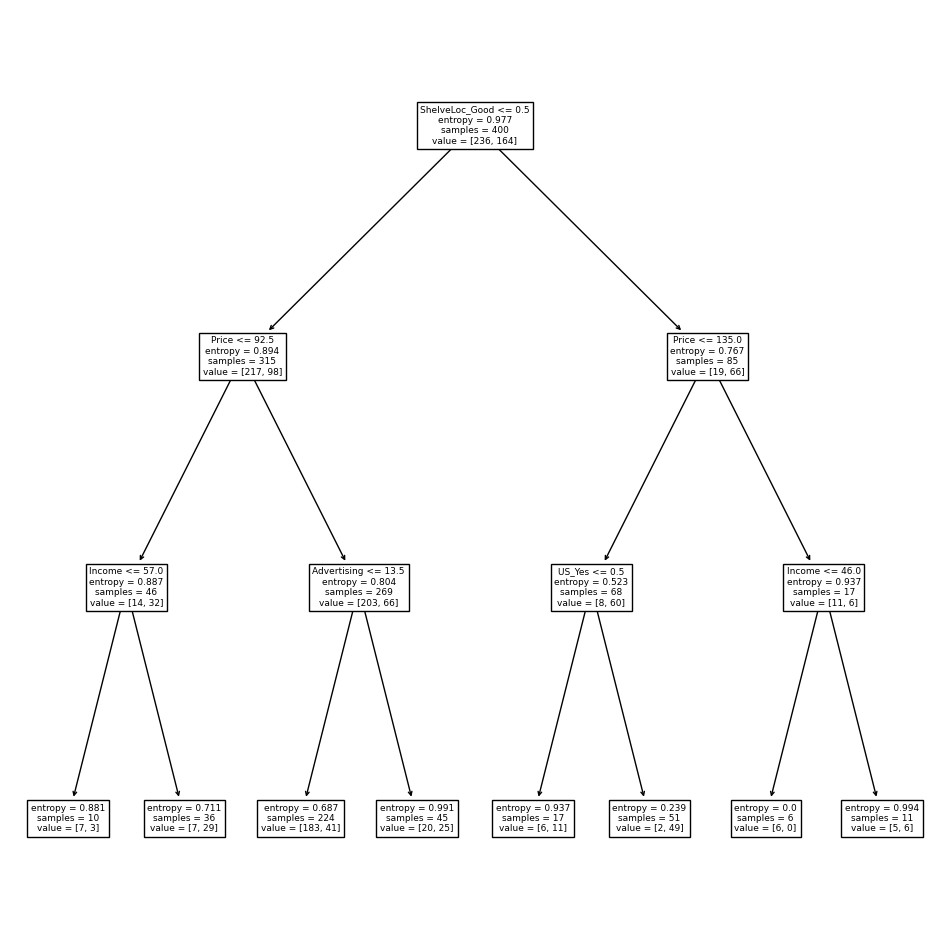

In [13]:
ax = subplots(figsize=(12,12))[1]
plot_tree(clf ,
        feature_names=feature_names ,
        ax=ax)

In [14]:
print(export_text(clf,feature_names=feature_names,show_weights=True))

|--- ShelveLoc_Good <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- weights: [7.00, 3.00] class: no
|   |   |--- Income >  57.00
|   |   |   |--- weights: [7.00, 29.00] class: yes
|   |--- Price >  92.50
|   |   |--- Advertising <= 13.50
|   |   |   |--- weights: [183.00, 41.00] class: no
|   |   |--- Advertising >  13.50
|   |   |   |--- weights: [20.00, 25.00] class: yes
|--- ShelveLoc_Good >  0.50
|   |--- Price <= 135.00
|   |   |--- US_Yes <= 0.50
|   |   |   |--- weights: [6.00, 11.00] class: yes
|   |   |--- US_Yes >  0.50
|   |   |   |--- weights: [2.00, 49.00] class: yes
|   |--- Price >  135.00
|   |   |--- Income <= 46.00
|   |   |   |--- weights: [6.00, 0.00] class: no
|   |   |--- Income >  46.00
|   |   |   |--- weights: [5.00, 6.00] class: yes



In [15]:
validation = skm.ShuffleSplit(n_splits=1,test_size=200,random_state=0)
results = skm.cross_validate(clf,carseats,high,cv=validation)
results['test_score']

array([0.685])

## Look at pruning the tree, but first divide the tree

In [16]:
# This does a 50-50 split

(x_train, x_test,high_train,high_test) = skm.train_test_split(x,high,test_size=0.5,random_state=0)

In [17]:
clf = DTC(criterion='entropy', random_state=0)
clf.fit(x_train , high_train)
accuracy_score(high_test , clf.predict(x_test))

0.735

When pruning a tree you have one tuning parameter $\alpha$

When pruning you are trying to minimize the following value for your subtrees

$T =$ your terminal nodes, $|T|$ is the number of terminal nodes, $T_0$ is the terminal nodes in an unpruned tree

$$\sum_{m=1}^{|T|}\sum_{x_i \in R_m}{(y_i - \hat{y_{R_m}})^2} + \alpha|T|$$

If $\alpha = 0$ you have an unpruned tree, the larger the $\alpha$ the more leaves you prune

[`sklearn.tree.DecisionTreeClassifier.cost_complexity_pruning_path`](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html) returns the effective alphas and the corresponding total leaf impurities at each step of the pruning process. As alpha increases, more of the tree is pruned, which increases the total impurity of its leaves. It uses Gini index to measure the impurities because that is the default of the `DecisionTreeClassifier`

$$ G = \sum_{k=1}^K(\hat{p}_{mk}(1-\hat{p}_{mk})) $$

Note: $K = $ number of classes, $\hat{p}_{mk}$ is teh proportion of training observations in the $m_{th}$ region tha are from the $k_{th}$ class.

Once you have your possible alphas, you want to retrain you model to see which alpha provides the best accuracy

In [18]:
ccp_path = clf.cost_complexity_pruning_path(x_train , high_train)
kfold = skm.KFold(10,random_state=1,shuffle=True)

In [19]:
ccp_path

{'ccp_alphas': array([0.        , 0.01622556, 0.0171946 , 0.0180482 , 0.0180482 ,
        0.01991688, 0.02012073, 0.02070855, 0.02193427, 0.0219518 ,
        0.02220877, 0.02274806, 0.02417233, 0.02588672, 0.02714959,
        0.02735525, 0.02900052, 0.02906078, 0.03209543, 0.04499252,
        0.06236632, 0.10024835]),
 'impurities': array([0.        , 0.01622556, 0.05061477, 0.06866297, 0.08671117,
        0.12654492, 0.14666566, 0.16737421, 0.18930848, 0.21126028,
        0.25567782, 0.27842588, 0.32677055, 0.35265727, 0.43410604,
        0.54352706, 0.57252758, 0.65970991, 0.72390076, 0.8138858 ,
        0.87625212, 0.97650047])}

In [20]:
grid = skm.GridSearchCV(clf ,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True ,
                        cv=kfold ,
                        scoring='accuracy')

grid.fit(x_train , high_train)
grid.best_score_

0.685

[Text(0.4345703125, 0.95, 'Price <= 94.5\nentropy = 0.977\nsamples = 200\nvalue = [118, 82]'),
 Text(0.1875, 0.85, 'CompPrice <= 118.5\nentropy = 0.769\nsamples = 40\nvalue = [9, 31]'),
 Text(0.15625, 0.75, 'Price <= 86.5\nentropy = 0.894\nsamples = 29\nvalue = [9, 20]'),
 Text(0.09375, 0.65, 'Income <= 60.0\nentropy = 0.523\nsamples = 17\nvalue = [2, 15]'),
 Text(0.0625, 0.55, 'Advertising <= 5.0\nentropy = 0.971\nsamples = 5\nvalue = [2, 3]'),
 Text(0.03125, 0.45, 'entropy = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.09375, 0.45, 'entropy = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(0.125, 0.55, 'entropy = 0.0\nsamples = 12\nvalue = [0, 12]'),
 Text(0.21875, 0.65, 'Population <= 212.5\nentropy = 0.98\nsamples = 12\nvalue = [7, 5]'),
 Text(0.1875, 0.55, 'entropy = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(0.25, 0.55, 'Income <= 36.5\nentropy = 0.954\nsamples = 8\nvalue = [3, 5]'),
 Text(0.21875, 0.45, 'entropy = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(0.28125, 0.45, 'entropy = 0.0\n

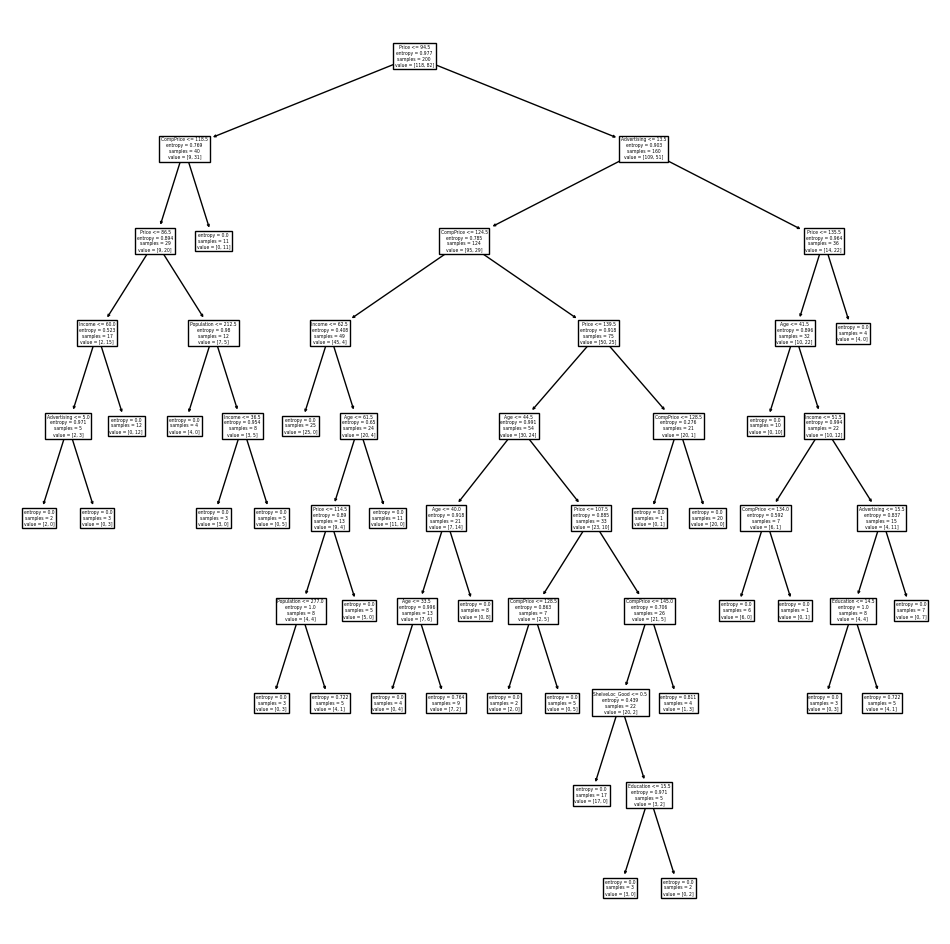

In [21]:
ax = subplots(figsize=(12, 12))[1]
best_ = grid.best_estimator_
plot_tree(best_,feature_names=feature_names,ax=ax)

In [22]:
best_.tree_.n_leaves

30

In [23]:
accuracy_score(high_test, best_.predict(x_test))

0.72

In [24]:
predict_test = best_.predict(x_test)
confusion = confusion_table(high_test, predict_test)
confusion

Truth,no,yes
Predicted,,
no,94,32
yes,24,50


# Regression Trees

In [32]:
boston = load_data("Boston")
features = boston.drop(columns = 'medv', axis=1)
feature_names = list(features.columns)
x = np.asarray(features)
(x_train,x_test,y_train,y_test) = skm.train_test_split(x,boston['medv'],test_size=0.3,random_state=0)

[Text(0.5, 0.875, 'rm <= 6.797\nsquared_error = 84.765\nsamples = 354\nvalue = 22.745'),
 Text(0.25, 0.625, 'lstat <= 14.405\nsquared_error = 35.011\nsamples = 284\nvalue = 19.614'),
 Text(0.125, 0.375, 'dis <= 1.474\nsquared_error = 20.776\nsamples = 167\nvalue = 22.981'),
 Text(0.0625, 0.125, 'squared_error = 0.0\nsamples = 2\nvalue = 50.0'),
 Text(0.1875, 0.125, 'squared_error = 12.072\nsamples = 165\nvalue = 22.653'),
 Text(0.375, 0.375, 'crim <= 5.782\nsquared_error = 16.049\nsamples = 117\nvalue = 14.808'),
 Text(0.3125, 0.125, 'squared_error = 10.345\nsamples = 67\nvalue = 16.872'),
 Text(0.4375, 0.125, 'squared_error = 10.334\nsamples = 50\nvalue = 12.042'),
 Text(0.75, 0.625, 'rm <= 7.435\nsquared_error = 85.388\nsamples = 70\nvalue = 35.451'),
 Text(0.625, 0.375, 'crim <= 7.393\nsquared_error = 44.147\nsamples = 47\nvalue = 30.921'),
 Text(0.5625, 0.125, 'squared_error = 19.597\nsamples = 43\nvalue = 32.465'),
 Text(0.6875, 0.125, 'squared_error = 6.997\nsamples = 4\nvalue = 

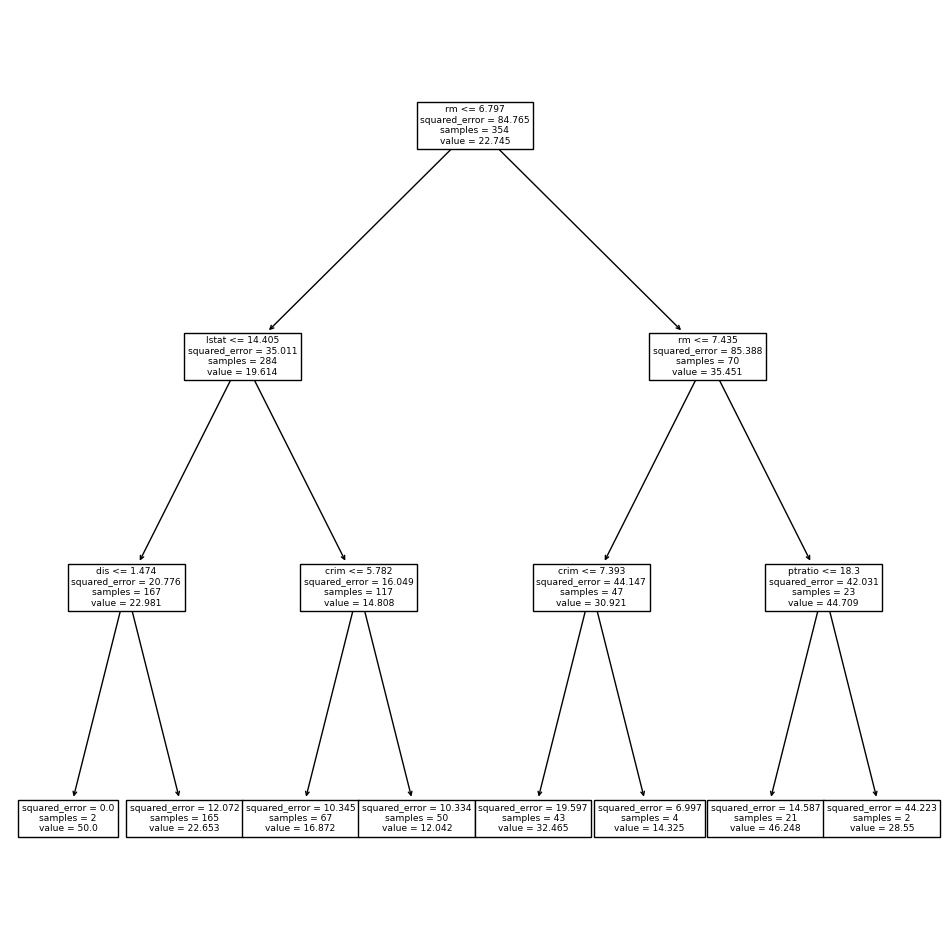

In [33]:
reg = DTR(max_depth=3)
reg.fit(x_train , y_train)
ax = subplots(figsize=(12,12))[1]
plot_tree(reg,feature_names=feature_names,ax=ax)

In [36]:
ccp_path = reg.cost_complexity_pruning_path(x_train , y_train)
kfold = skm.KFold(5,shuffle=True,random_state =10)
grid = skm.GridSearchCV(reg,{'ccp_alpha': ccp_path.ccp_alphas},refit=True,cv=kfold,scoring='neg_mean_squared_error')
g = grid.fit(x_train, y_train)

In [37]:
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(x_test))**2)

28.06985754975404

# Bagging and Boosting

## Bagging

In [45]:
# max_features specifies how many predictors to use. When set to the max number of features you are using Bagging, anything less is a random forest
bag_boston = RF(max_features=x_train.shape[1], random_state=0)
bag_boston.fit(x_train, y_train)

RandomForestRegressor(max_features=12, random_state=0)

14.634700151315787

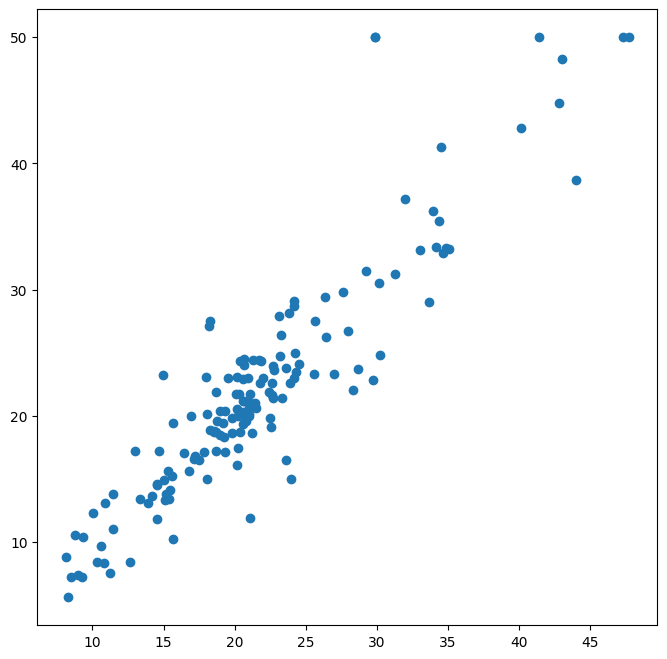

In [46]:
ax = subplots(figsize=(8,8))[1]
y_hat_bag = bag_boston.predict(x_test)
ax.scatter(y_hat_bag, y_test)
np.mean((y_test - y_hat_bag)**2)

In [48]:
# now changing the number of trees grown
bag_boston = RF(max_features=x_train.shape[1],
                n_estimators=500,
                random_state=0).fit(x_train, y_train)
y_hat_bag = bag_boston.predict(x_test)
np.mean((y_test - y_hat_bag)**2)

14.605662565263161

## Random Forest

In [50]:
RF_boston = RF(max_features=6,
               random_state=0).fit(x_train, y_train)
y_hat_RF = RF_boston.predict(x_test)
np.mean((y_test - y_hat_RF)**2)

20.04276446710527

In [51]:
# Look at the importance of each feature
feature_imp = pd.DataFrame(
    {'importance':RF_boston.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
lstat,0.356203
rm,0.332163
ptratio,0.067270
crim,0.055404
indus,0.053851
dis,0.041582
nox,0.035225
tax,0.025355
age,0.021506
rad,0.004784


The result above indicates that across all of the trees considered in the random forest, the wealth level of the community (lstat) and the house size (rm) are by far the two most important variables.

## Boosting

[`GradientBoostingRegressor()`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor) from `sklearn.ensemble` to fit boosted regression trees to the Boston data set. For classification we would use GradientBoostingClassifier(). The argument n_estimators=5000 indicates that we want 5000 trees, and the option max_depth=3 limits the depth of each tree. The argument learning_rate is the  

In [52]:
boost_boston = GBR(n_estimators=5000,
                   learning_rate=0.001,
                   max_depth=3,
                   random_state=0)
boost_boston.fit(x_train, y_train)

GradientBoostingRegressor(learning_rate=0.001, n_estimators=5000,
                          random_state=0)

In [53]:
np.zeros_like(boost_boston.train_score_)

array([0., 0., 0., ..., 0., 0., 0.])

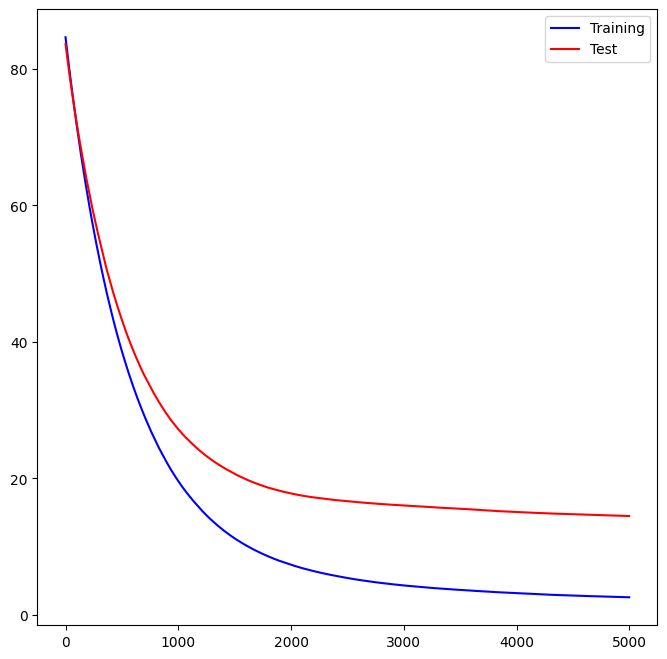

In [57]:
test_error = np.zeros_like(boost_boston.train_score_)
for idx , y_ in enumerate(boost_boston.staged_predict(x_test)):
    test_error[idx] = np.mean((y_test - y_)**2)

plot_idx = np.arange(boost_boston.train_score_.shape[0])
ax = subplots(figsize=(8,8))[1]
ax.plot(plot_idx , boost_boston.train_score_,'b',label='Training')
ax.plot(plot_idx,test_error,'r',label='Test')
ax.legend()

In [58]:
y_hat_boost = boost_boston.predict(x_test)
np.mean((y_test - y_hat_boost)**2)

14.481405918831591

In [59]:
# try a different lambda (learning_rate)
boost_boston = GBR(n_estimators=5000,
                   learning_rate=0.2,
                   max_depth=3,
                   random_state=0)
boost_boston.fit(x_train,
                 y_train)
y_hat_boost = boost_boston.predict(x_test);
np.mean((y_test - y_hat_boost)**2)

14.501514553719565